## Adversarial Attack

In [1]:
# %pip install -q pillow
# %pip install -q numpy
# %pip install -q scipy
# %pip install -q matplotlib
# %pip install -q torchinfo
# %pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from torchvision.transforms import v2
from torchvision.utils import make_grid
from torchvision.models import vgg19, VGG19_Weights
from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchinfo import summary
from tqdm import tqdm, trange
from PIL import Image

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    if device.type == "cuda":
        # Allow TensorFloat32 on matmul and convolutions
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        # torch.set_float32_matmul_precision("medium")

print(f"Available device: {device.type}")
torch.set_default_device(device)

Available device: cuda


In [4]:
preprocess_fn = v2.Compose(
    [
        v2.Resize((512, 512)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

postprocess_fn = v2.Compose(
    [
        v2.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
        ),
        v2.ToPILImage(),
    ]
)

In [5]:
class ContentLoss(nn.Module):

    def __init__(
        self,
        target,
    ):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [6]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [8]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [9]:
# desired depth layers to compute style/content losses :
content_layers_default = ["conv_4"]
style_layers_default = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]


def get_style_model_and_losses(
    cnn,
    style_img,
    content_img,
    content_layers=content_layers_default,
    style_layers=style_layers_default,
):
    # normalization module
    normalization = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = "conv_{}".format(i)
        elif isinstance(layer, nn.ReLU):
            name = "relu_{}".format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = "pool_{}".format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = "bn_{}".format(i)
        else:
            raise RuntimeError(
                "Unrecognized layer: {}".format(layer.__class__.__name__)
            )

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[: (i + 1)]

    return model, style_losses, content_losses

In [10]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = preprocess_fn(image).unsqueeze(0)
    return image.to(device, torch.float)

In [11]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = postprocess_fn(image)
    plt.imshow(image)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
def run_style_transfer(
    cnn,
    content_img,
    style_img,
    input_img,
    num_steps=300,
    style_weight=1000000,
    content_weight=1,
):
    """Run the style transfer."""
    print("Building the style transfer model..")
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, style_img, content_img
    )

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = torch.optim.LBFGS([input_img])

    print("Optimizing..")
    run = 0
    while run <= num_steps:

        def closure():
            nonlocal run
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run += 1
            if run % 50 == 0:
                print("run {}:".format(run))
                print(
                    "Style Loss : {:4f} Content Loss: {:4f}".format(
                        style_score.item(), content_score.item()
                    )
                )
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run 50:
Style Loss : 247.856949 Content Loss: 11.570498

run 100:
Style Loss : 47.362194 Content Loss: 12.167076

run 150:
Style Loss : 20.915598 Content Loss: 12.797041

run 200:
Style Loss : 13.020921 Content Loss: 12.622565

run 250:
Style Loss : 9.492237 Content Loss: 12.258604

run 300:
Style Loss : 7.177368 Content Loss: 11.979634

run 350:
Style Loss : 5.591981 Content Loss: 11.716866

run 400:
Style Loss : 4.470889 Content Loss: 11.399002

run 450:
Style Loss : 3.572580 Content Loss: 11.074097

run 500:
Style Loss : 2.963907 Content Loss: 10.795197



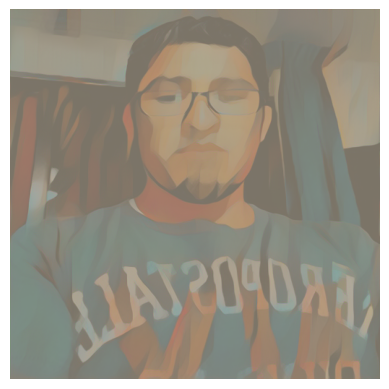

In [13]:
style_img = image_loader("../datasets/neural_transfer/pablo-picasso.jpg")
content_img = image_loader("../datasets/neural_transfer/me2.jpg")

input_img = content_img.clone().contiguous()

output = run_style_transfer(cnn, content_img, style_img, input_img, num_steps=500)

plt.figure()
imshow(output)

plt.ioff()
plt.show()